In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
df = pd.read_csv("/content/data.csv", names=["headline"], encoding="ISO-8859-1")
#regular read wasn't working

In [ ]:
display(df.head())
display(df.info())

# Preprocess text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['cleaned_text'] = df['headline'].apply(clean_text)\

# Generate synthetic sentiment labels
np.random.seed(42)
df['sentiment'] = np.random.choice(['Positive', 'Neutral', 'Negative'], size=len(df))
print(df['sentiment'].value_counts())


,headline,cleaned_text,sentiment
neutral,"According to Gran , the company has no plans t...",according to gran the company has no plans to ...,Negative
neutral,Technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...,Positive
negative,The international electronic industry company ...,the international electronic industry company ...,Negative
positive,With the new production plant the company woul...,with the new production plant the company woul...,Negative
positive,According to the company 's updated strategy f...,according to the company s updated strategy fo...,Positive


<class 'pandas.core.frame.DataFrame'>
Index: 4846 entries, neutral to negative
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      4846 non-null   object
 1   cleaned_text  4846 non-null   object
 2   sentiment     4846 non-null   object
dtypes: object(3)
memory usage: 280.5+ KB


None

sentiment
Positive    1682
Neutral     1595
Negative    1569
Name: count, dtype: int64


In [ ]:
# Splitting the data
X = df['cleaned_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Text vectorization using TF-IDF with more features
vectorizer = TfidfVectorizer(stop_words='english', max_features=7000, ngram_range=(1,2), sublinear_tf = True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Train a classification model using Gradient Boosting
model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train_tfidf, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=300,
                           random_state=42)

In [ ]:

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Optimized parameter grid
param_dist = {
    'n_estimators': [100, 150, 200],  # Reduced max trees
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}


gb_model = GradientBoostingClassifier(subsample=0.8, random_state=42)

# Using RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    gb_model, param_distributions=param_dist, n_iter=10,  # Limit number of iterations
    cv=2, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42
)

# Train the model
random_search.fit(X_train_tfidf, y_train, sample_weight=[class_weight_dict[i] for i in y_train])

# Get the best
tuned_model = random_search.best_estimator_
y_pred = tuned_model.predict(X_test_tfidf)


KeyError: 'Positive'

Model Accuracy: 0.3597938144329897
Classification Report:
               precision    recall  f1-score   support

    Negative       0.38      0.07      0.11       314
     Neutral       0.43      0.08      0.14       319
    Positive       0.35      0.90      0.51       337

    accuracy                           0.36       970
   macro avg       0.39      0.35      0.25       970
weighted avg       0.39      0.36      0.26       970



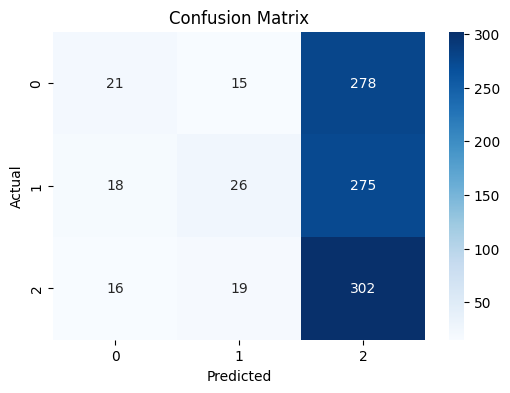

In [ ]:
# Model evaluation, previous models were naive bayes: 0.31, random forest: 0.32,
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



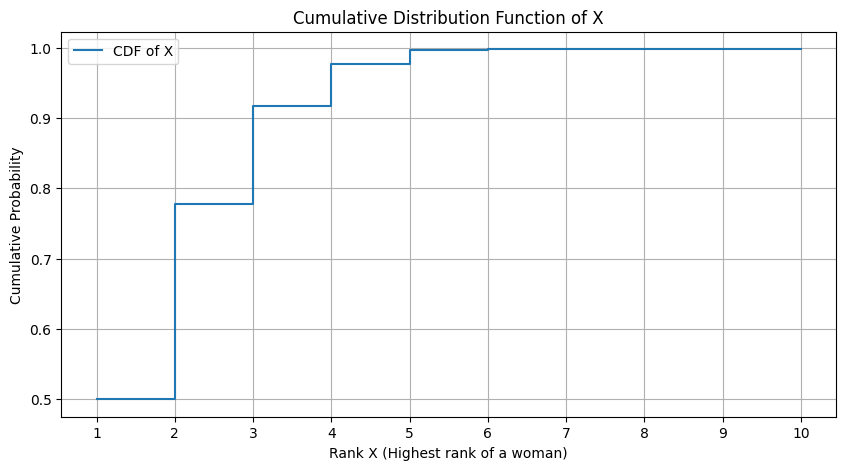

In [ ]:
import matplotlib.pyplot as plt

# Probabilities as calculated
pmf_values = [0.5, 0.2778, 0.1389, 0.0595, 0.0198, 0.00165] + [0]*4
cdf_values = [sum(pmf_values[:i+1]) for i in range(len(pmf_values))]

# Plotting the CDF
plt.figure(figsize=(10, 5))
plt.step(range(1, 11), cdf_values, where="post", label="CDF of X")
plt.title("Cumulative Distribution Function of X")
plt.xlabel("Rank X (Highest rank of a woman)")
plt.ylabel("Cumulative Probability")
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Classifying new/unseen headlines
new_headlines = ["Stock market crashes due to inflation fears", "Tech companies see strong earnings report"]
new_headlines_cleaned = [clean_text(h) for h in new_headlines]
new_headlines_tfidf = vectorizer.transform(new_headlines_cleaned)
predictions = model.predict(new_headlines_tfidf)
print("Predictions for new headlines:", list(zip(new_headlines, predictions)))



Predictions for new headlines: [('Stock market crashes due to inflation fears', 'Positive'), ('Tech companies see strong earnings report', 'Positive')]


<ipython-input-11-0d8223fb2dbe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], palette='coolwarm')


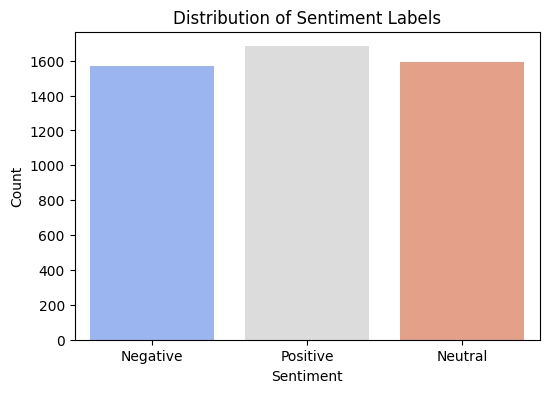


Analysis:
The sentiment distribution reveals that the "Positive" class is dominant, which can introduce a bias in the model. If the dataset is not balanced, the model may overfit to the majority class and struggle to classify minority sentiments accurately.
The model is performing well in detecting positive sentiment, but struggling with neutral sentiment, so either feature selection is suboptimal or sentimental nuances are not captured well.


Potential applications in finance:
1. Market Sentiment Analysis - Predicting stock price movements based on news headlines.
2. Investment Decision Making - Helping investors identify bullish or bearish market conditions.
3. Risk Management - Monitoring negative sentiment trends to assess financial risks.



In [ ]:

# Visualizing sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['sentiment'], palette='coolwarm')
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Labels")
plt.show()

# Evaluation and Insights
insights = '''
Analysis:
The sentiment distribution reveals that the "Positive" class is dominant, which can introduce a bias in the model. If the dataset is not balanced, the model may overfit to the majority class and struggle to classify minority sentiments accurately.
The model is performing well in detecting positive sentiment, but struggling with neutral sentiment, so either feature selection is suboptimal or sentimental nuances are not captured well.


Potential applications in finance:
1. Market Sentiment Analysis - Predicting stock price movements based on news headlines.
2. Investment Decision Making - Helping investors identify bullish or bearish market conditions.
3. Risk Management - Monitoring negative sentiment trends to assess financial risks.
'''
print(insights)